**On the fly image anlysis in microscopy**

* Reward-Driven analysis
* Real-time analysis and human in the loop control

May, 2025

Notebook prepared by **Kamyar Barakati**

Nural network developed by Maxim Ziatdinov in AtomAI Python library

Install packages

In [2]:
import time

before = time.time()
!pip install git+https://github.com/pycroscopy/atomai

! pip install platypus-opt

! pip install scikit-optimize scipy numpy

after = time.time()
print(f"Time taken: {after - before} seconds")

  Cloning https://github.com/pycroscopy/atomai to /tmp/pip-req-build-2alch_xh
  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/atomai /tmp/pip-req-build-2alch_xh
  Resolved https://github.com/pycroscopy/atomai to commit 17528af8e9eb818540cead746584bffafd079339
  Preparing metadata (setup.py) ... done
  Using cached mendeleev-0.6.1.tar.gz (193 kB)
  Preparing metadata (setup.py) ... done
  Using cached gpytorch-1.14-py3-none-any.whl.metadata (8.0 kB)
  Using cached jaxtyping-0.3.2-py3-none-any.whl.metadata (7.0 kB)
  Using cached linear_operator-0.6-py3-none-any.whl.metadata (15 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached pyfiglet-1.0.2-py3-none-any.whl.metadata (7.1 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4

In [ ]:
# !pip install pymoo

In [ ]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.4.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')

Import libraries

In [4]:
import atomai as aoi
# from atomai.transforms import datatransform
from platypus import Problem, Real, NSGAII, Solution, Integer
from PIL import Image
from skimage import feature, io
from skimage import filters, img_as_float
from sklearn.neighbors import NearestNeighbors
import random
import math
import cv2
import time
import pickle
from scipy.stats import gaussian_kde
from matplotlib.ticker import FuncFormatter
import plotly.graph_objs as go
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

import os
import numpy as np
import matplotlib.pyplot as plt

import pyTEMlib
import pyTEMlib.file_tools as ft
import pyTEMlib.image_tools as it
from pyTEMlib.atom_tools import atom_refine
from pyTEMlib import graph_tools as gt
from pyTEMlib import crystal_tools as ct

from skimage.feature import blob_log
from scipy.spatial import KDTree
from scipy.signal import correlate
from scipy.signal import correlate2d
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from collections import defaultdict, deque

from scipy.spatial import Delaunay, Voronoi, ConvexHull, voronoi_plot_2d
from scipy.spatial import cKDTree

from matplotlib import cm
import matplotlib.patches as patches
import matplotlib as mpl

from IPython.display import clear_output, display
import ipywidgets as widgets

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
Qt dialogs are not available
SimpleITK not installed; Registration Functions for Image Stacks not available
install with: conda install -c simpleitk simpleitk 


# Upload:

- Experiemental graphene data
- Experiemental graphene stack of images
- DCNN weights from atomai

**Graphene**

**SrTiO3**

In [5]:
! gdown 12dJWNSdmHcZQkmWzXgH2u4aiJQrjcrNP
! gdown 1IecDXMHqFQgvTMluTnsHXqayk0cVmX3x

Downloading...
From: https://drive.google.com/uc?id=1IecDXMHqFQgvTMluTnsHXqayk0cVmX3x
To: /content/graphene.emd
100% 86.9M/86.9M [00:00<00:00, 102MB/s]


In [6]:
path = '/content/'
files = os.listdir(path)
files = [f for f in files if "emd" in f]

files.sort()
files

['graphene.emd']

In [7]:
dset = ft.open_file(path + files[0])
image = dset['Channel_000']

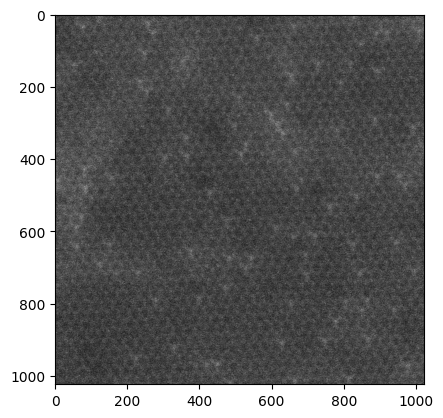

In [8]:
plt.imshow(image[0], cmap='gray')

In [9]:
avg_im = image.sum(axis=0)
avg_im.data_type = 'IMAGE'
avg_im -= avg_im.min()
avg_im /= avg_im.max()

In [10]:
def make_gauss(size_x, size_y, width=1.0, x0=0.0, y0=0.0, intensity=1.0):
    """Make a Gaussian shaped probe """
    size_x = size_x / 2
    size_y = size_y / 2
    x, y = np.mgrid[-size_x:size_x, -size_y:size_y]
    g = np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / 2.0 / width ** 2)
    probe = g / g.sum() * intensity
    return probe

  0%|          | 0/500 [00:00<?, ?it/s]

converged in 109 iterations

 Lucy-Richardson deconvolution converged in 109  iterations


Text(0.5, 1.0, 'LR_decon')

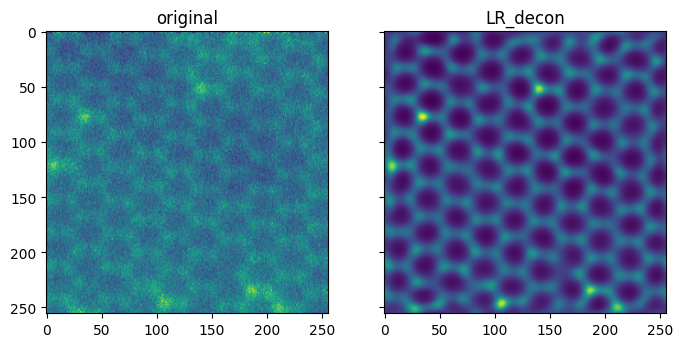

In [17]:
# ------- Input ------
atoms_size = 0.08
# --------------------

# scale = image.x.values[1]

scale = avg_im.x.values[1]
image = avg_im[0:256, 0:256]

image.metadata['experiment']= {'convergence_angle': 30, 'acceleration_voltage': 60000.}
gauss_diameter = atoms_size/scale
gauss_probe = make_gauss(image.shape[0], image.shape[1], gauss_diameter)
lr_dataset = it.decon_lr(image, gauss_probe, verbose=False)

fig, ax = plt.subplots(1,2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T)
ax[0].set_title('original')
ax[1].imshow(lr_dataset.T)
ax[1].set_title('LR_decon')


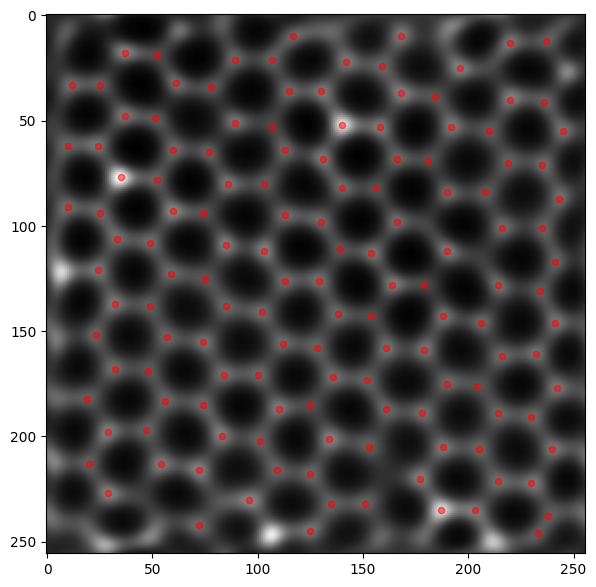

In [31]:
# ------- Input ------
threshold = 0.01 #usally between 0.01 and 0.9  the smaller the more atoms
# ----------------------

blobs_m = blob_log(lr_dataset, max_sigma=10, threshold=threshold)

blobs_m = pyTEMlib.graph_tools.delete_rim_atoms(blobs_m, lr_dataset.shape, 10)


fig, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
ax.imshow(lr_dataset.T, cmap='gray')
ax.scatter(blobs_m[:, 0], blobs_m[:, 1], c='r', s=20, alpha = .5)

In [19]:
print(len(blobs_m))

138


Load DCNN model for comparison

In [20]:
# download data
# !gdown "https://drive.google.com/uc?id=18U8YHZUbSZj0Q1__zup5-ABrjaEZmiPc"
# download model
!gdown "https://drive.google.com/uc?id=18PQs7M_fBp4Lf0JVQlORERmBmYRJ88-M"
# download DCNN weights Graphene
!gdown 1SYEhCvo2-Bdv37Od0VZohurlnm3LSWCB
#Hexagonal train/test dataset
# !wget -O "Hex_train_test3.npz" https://www.dropbox.com/s/aldxrawcf88btkc/Hex_train_test3.npz?dl=0

Downloading...
From: https://drive.google.com/uc?id=18PQs7M_fBp4Lf0JVQlORERmBmYRJ88-M
To: /content/G_MD.tar
100% 11.1M/11.1M [00:00<00:00, 183MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SYEhCvo2-Bdv37Od0VZohurlnm3LSWCB
To: /content/abc.tar
100% 7.21M/7.21M [00:00<00:00, 136MB/s]


In [21]:
model = aoi.load_model("G_MD.tar")

In [22]:
exp_img = lr_dataset

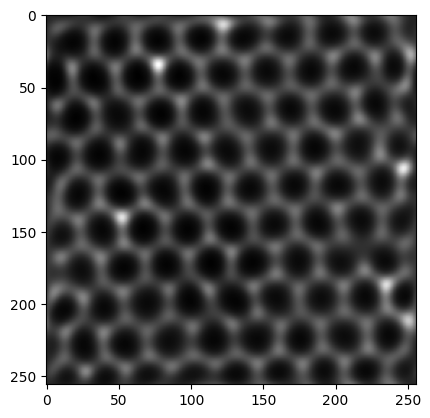

In [23]:
plt.imshow(exp_img, cmap="gray")

#RDW test on pre aquired data

In [24]:
def apply_gaussian_smoothing(image, sigma):

    # Convert the image to float to prevent data type overflow
    image_float = img_as_float(image)

    # Apply Gaussian filter
    smoothed_image = filters.gaussian(image_float, sigma=sigma)

    return smoothed_image

In [25]:
# min-max normalization:
def norm2d(img: np.ndarray) -> np.ndarray:
    return (img - np.min(img)) / (np.max(img) - np.min(img))

## DCNN performance

In [26]:
test_img = apply_gaussian_smoothing(exp_img, 0)

In [27]:
nn_output, coordinates = model.predict(test_img)

Batch 1/1
1 image was decoded in approximately 0.9568 seconds


How it worked?

In [28]:
print(len(coordinates[0]))

156


Compare:

In [29]:
print(len(coordinates[0]) - len(blobs_m))

18


<ipython-input-30-953d60907375>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  imglab = ax.scatter(x, y,  marker='o', c="r" , s = 50 ,cmap='coolwarm', edgecolor='k')


[]

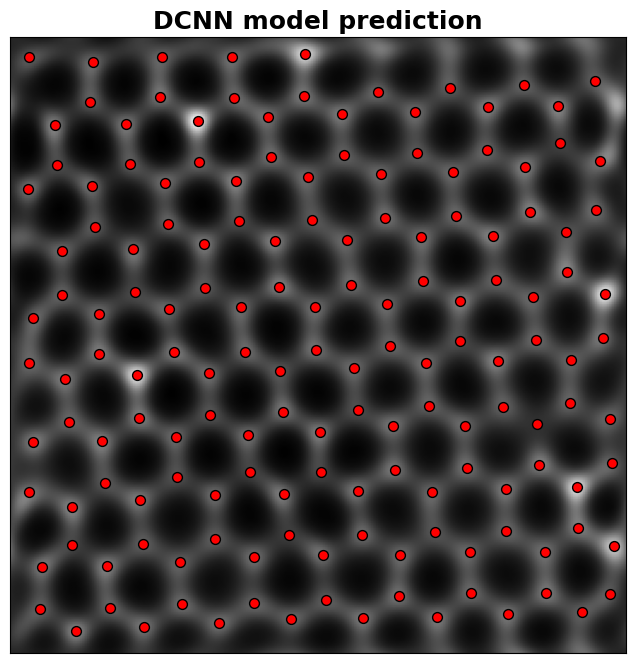

In [30]:
x = coordinates[0][:, 1]
y = coordinates[0][:, 0]
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(test_img, cmap='gist_gray')

imglab = ax.scatter(x, y,  marker='o', c="r" , s = 50 ,cmap='coolwarm', edgecolor='k')
plt.title('DCNN model prediction' , fontsize = 18, fontweight = "bold")
ax.set_xticks([])
ax.set_yticks([])

## RDW performance

In [32]:
def apply_log_one(min_sigma, max_sigma, threshold, overlap):

    #img = imgdata_noisy
    img = test_img
    preprocessed_img = norm2d(np.array(img))
    array_3d = preprocessed_img[None, :, :]

    num_sigma = 10
    window_size = 15

    # Initialize arrays for results
    coordinates = np.zeros((1, 3))
    coms = np.zeros((1, 3))
    imstack_grid = np.zeros((1, window_size, window_size, 1))

    # Process the preprocessed image
    imglist = [0]  # Assuming you're processing a single image in this case
    for i in imglist:
        img_to_analyze = norm2d(array_3d[i])  # Apply norm2d to the slice from array_3d

        # Apply LoG filter to detect atoms using the provided parameters
        all_atoms = feature.blob_log(preprocessed_img, min_sigma=min_sigma, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold, overlap=overlap)

        if len(all_atoms) == 0:
            return np.array([]), 0

        coordinate = np.full_like(all_atoms, i)
        coordinate[:, :-1] = all_atoms[:, :-1]

        # Attempt to extract sub-images around detected atoms
        try:
            imstack, com, frames = aoi.utils.extract_subimages(img_to_analyze, coordinate[:, :-1], window_size)
            com = np.array(com)
            if com.size == 0:  # Check if the 'com' array is empty
                continue  # Skip the rest of the loop if no sub-images were extracted

            com_ = np.full((len(com), 3), i)
            com_[:, :-1] = com
            imstack = (imstack - imstack.min()) / (imstack.max() - imstack.min())  # Normalize sub-images

            # Accumulate results
            coms = np.concatenate((coms, com_), axis=0)
            coordinates = np.concatenate((coordinates, coordinate), axis=0)
            imstack_grid = np.concatenate((imstack_grid, imstack), axis=0)
        except ValueError as e:
            print(f"Error processing image index {i}: {e}")
            continue  # Optionally log the error and skip this iteration

    # Remove the initial placeholder row
    coordinates = coordinates[1:]
    coms = coms[1:]
    imstack_grid = imstack_grid[1:]

    return coms, len(coms)

**Quality Function: Objective 1**

The Quality_count function is designed to evaluate the performance Laplacian of Gaussian method in atom detection based on a comparison between the number of atoms detected by the apply_log function and a pre-established number of atoms drived from materials lattice structure.



Define Oracle based on the material's unit cell size

In [33]:
def calculate_total_points(image, unit_cell_length, unit_cell_width, atoms_per_unit_cell):

    # Get the dimensions of the cropped and normalized image
    image_height, image_width = image.shape

    # Calculate the image area
    image_area = image_width * image_height

    # Calculate the unit cell area
    unit_cell_area = unit_cell_length * unit_cell_width

    # Determine the number of unit cells in the image
    number_of_unit_cells = image_area / unit_cell_area

    # Multiply by the number of atoms per unit cell
    total_points = (number_of_unit_cells * atoms_per_unit_cell)*1.1
    total_points = math.floor(total_points)
    return total_points

In [34]:
unit_cell_length = 50
unit_cell_width = 50
atoms_per_unit_cell = 6
Oracle = calculate_total_points(test_img, unit_cell_length, unit_cell_width, atoms_per_unit_cell)
print(Oracle)

173


In [35]:
# Oracle = 1100

In [36]:
def Quality_count(params):
    min_sigma, max_sigma, threshold, overlap = params
    coms, log_count = apply_log_one(min_sigma, max_sigma, threshold, overlap)

    difference = abs((log_count - Oracle)/Oracle)

    return difference

**Error Function: Objective 2**

Identifies false positives in atom detection by calculating the sum of distances between neighboring atoms and normalizing the result based on a threshold relative to lattice parameters.

Sum of distances to the nearest neighbors: 49.35


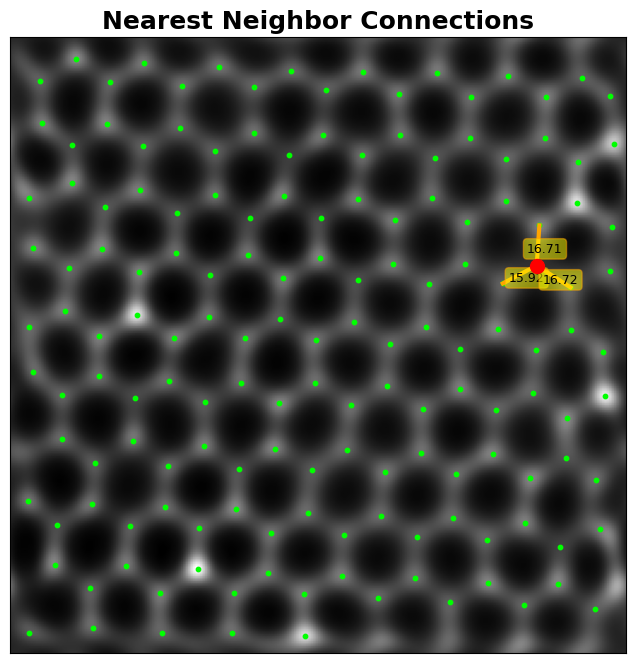

In [38]:
coms = coordinates[0][:,:-1]

# Use NearestNeighbors from scikit-learn to find the 3 nearest neighbors
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(coms)

# Find the distances and indices of the 3 nearest neighbors for each atom
distances, indices = nbrs.kneighbors(coms)

# Exclude the first column (distance to the point itself)
nearest_distances = distances[:, 1:]
nearest_indices = indices[:, 1:]

# Plot the atom coordinates
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(test_img, cmap='gist_gray')
ax.scatter(coms[:, 1], coms[:, 0], s=10, c='lime')

# Randomly select a point within the defined area
selected_point_index = random.choice(range(len(coms)))
selected_point = coms[selected_point_index]

# Highlight the selected point
ax.scatter(selected_point[1], selected_point[0], s=100, c='red', zorder=5)

# Draw lines to the four nearest neighbors and annotate them with the distances
for i, neighbor_index in enumerate(nearest_indices[selected_point_index]):
    neighbor_point = coms[neighbor_index]
    line = ax.plot([selected_point[1], neighbor_point[1]], [selected_point[0], neighbor_point[0]], 'orange', linewidth=3, zorder=3)

    # Get the middle of the line to place the text
    mid_point = [(selected_point[1] + neighbor_point[1]) / 2, (selected_point[0] + neighbor_point[0]) / 2]

    # Annotate the line with distance
    ax.annotate(f"{nearest_distances[selected_point_index, i]:.2f}",
                mid_point,
                textcoords="offset points",
                xytext=(5,-5),
                ha='center',
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='orange', facecolor='yellow', alpha=0.5))

ax.set_title('Nearest Neighbor Connections', fontsize=18, fontweight='bold')
ax.set_xticks([])
ax.set_yticks([])

# Sum of the distances to the 3 nearest neighbors for the selected point
sum_of_nearest_distances = np.sum(nearest_distances[selected_point_index])
print(f"Sum of distances to the nearest neighbors: {sum_of_nearest_distances:.2f}")

# Configure the tick parameters
ax.invert_yaxis()
plt.show()

In [39]:
# lattice_param_limit = sum_of_nearest_distances+(sum_of_nearest_distances)*10/100
lattice_param_limit = sum_of_nearest_distances
lattice_param_limit

np.float64(49.35491234073503)

In [40]:
def Error_count(params):
    min_sigma, max_sigma, threshold, overlap = params


    # Assume apply_log is defined elsewhere and returns coordinates and log_count
    coms, log_count = apply_log_one(min_sigma, max_sigma, threshold, overlap)

    # Safeguard for n_neighbors to not exceed number of samples
    n_neighbors = min(len(coms), 4)  # Ensure n_neighbors does not exceed the number of samples in coms

    # Calculate the sum of distances to the nearest neighbors for each point
    if n_neighbors > 1:  # Proceed only if there are at least 2 points (1 neighbor besides itself)
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(coms)
        distances, _ = nbrs.kneighbors(coms)
        sum_of_distances = np.sum(distances[:, 1:], axis=1)  # Exclude the distance to itself (first column)
    else:
        sum_of_distances = np.array([0] * len(coms))  # If only 1 sample, the sum of distances is 0

    # Count points with the sum of distances below a certain threshold
    points_below_threshold = np.sum(sum_of_distances < lattice_param_limit)

    normalized_points = points_below_threshold / Oracle  # Assuming Oracle_A is defined and non-zero


    return normalized_points

**Multi-Objective Optimization**

The provided funcrions define and execute a multi-objective optimization problem using the **NSGA-II** algorithm. The main goal of this optimization is to minimize two objectives (Error_count, and Quality_count) by adjusting certain hyper-parameters (threshold, overlap).

 - min_sigma=min_sigma,
 - max_sigma=max_sigma,

 - threshold=threshold,
 - overlap=overlap

In [42]:
# Define your problem as a class inheriting from Problem
class MyOptimizationProblem(Problem):
    def __init__(self):
        # Initialize the problem with 4 decision variables and 2 objectives
        super(MyOptimizationProblem, self).__init__(4, 2)

        self.types[:] = [Real(1, 20), Real(10, 40), Real(0.01, 0.1), Real(0.01, 1.0)]

        self.directions[:] = [Problem.MINIMIZE, Problem.MINIMIZE]  # Assuming both objectives are to be minimized

    def evaluate(self, solution):
        #min_sigma, max_sigma, threshold, overlap = solution.variables
        min_sigma, max_sigma, threshold, overlap = solution.variables

        error = Error_count([min_sigma, max_sigma, threshold, overlap])
        quality = Quality_count([min_sigma, max_sigma, threshold, overlap])

        #Ensure the objectives are returned as a list or array of two values
        solution.objectives[:] = [error, quality]

In [44]:
import time

problem = MyOptimizationProblem()

before = time.time()
# Solve the problem using the NSGA-II algorithm
algorithm = NSGAII(problem)

algorithm.run(10)  # Adjust the number of iterations as needed

# After the run, you can extract the Pareto-optimal solutions
for solution in algorithm.result:
    print(f"Objectives: {solution.objectives}, Parameters: {solution.variables}")

after = time.time()
print(after-before)

Objectives: [0.023121387283236993, 0.2774566473988439], Parameters: [2.033656173358353, 37.14839882223915, 0.023686504993980926, 0.258194986431092]
Objectives: [0.0, 1.0], Parameters: [18.80878118644514, 14.266226994726463, 0.07250526110576505, 0.5715036745786191]
Objectives: [0.0, 1.0], Parameters: [17.173096418358927, 25.52736926677287, 0.07595030885292858, 0.1412305566319421]
Objectives: [0.0, 0.9826589595375722], Parameters: [10.784946946214818, 24.032340719734194, 0.05767914997097511, 0.5708765671094327]
Objectives: [0.0, 0.9884393063583815], Parameters: [11.882749855373378, 37.96530991732402, 0.09738653342601249, 0.4899068621981781]
Objectives: [0.023121387283236993, 0.23699421965317918], Parameters: [5.900272487869941, 30.0710420632707, 0.029811226993141114, 0.16268574202341246]
Objectives: [0.0, 0.9826589595375722], Parameters: [13.265166557751341, 31.28630215366493, 0.03336415655404798, 0.6627934241555512]
Objectives: [0.05202312138728324, 0.16184971098265896], Parameters: [4.

In [45]:
# Print results
solutions = [(solution.variables, solution.objectives) for solution in algorithm.result]

Pareto front olutions

In [46]:
# e.g., solutions = algorithm.result
objectives = [s[1] for s in solutions]
obj1 = [o[0] for o in objectives]
obj2 = [o[1] for o in objectives]

# Create slider for selecting solution index
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(solutions) - 1,
    step=1,
    description='Solution Index:',
    continuous_update=False
)

# Output area for hyperparams & plot
output = widgets.Output()

def update_plot(change):
    idx = change['new']
    hp, objs = solutions[idx]

    with output:
        clear_output(wait=True)
        # Display hyperparameters and objective values
        print(f"Hyperparameters: {hp}")
        print(f"Objective 1: {objs[0]:.4f}")
        print(f"Objective 2: {objs[1]:.4f}")

        # Plot all points and highlight the selected one
        plt.figure(figsize=(5, 5), dpi=150)
        plt.scatter(obj1, obj2, s=40, marker='o', c="blue", alpha=0.5)
        plt.scatter(obj1[idx], obj2[idx], s=100, marker='*', c="red")
        plt.title(f"Solution #{idx}", fontsize=14, fontweight="bold")
        plt.xlabel('Objective 1', fontsize=12, fontweight="bold")
        plt.ylabel('Objective 2', fontsize=12, fontweight="bold")
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        plt.grid(True)
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Link slider changes to update function
slider.observe(update_plot, names='value')

# Display interactive widget
display(widgets.VBox([slider, output]))

# Initial display
update_plot({'new': 0})


In [47]:
# build lists of objectives and variables
solutions = [(sol.variables, sol.objectives) for sol in algorithm.result]
obj1 = np.array([o[1][0] for o in solutions])   # reward1
obj2 = np.array([o[1][1] for o in solutions])   # reward2

# 1) the solution with maximum reward1 (tie-break by minimum reward2)
idx_max1_min2 = max(
    range(len(solutions)),
    key=lambda i: (obj1[i], -obj2[i])
)

# 2) the solution with maximum reward2 (tie-break by minimum reward1)
idx_max2_min1 = max(
    range(len(solutions)),
    key=lambda i: (obj2[i], -obj1[i])
)

# unpack
vars_max1, objs_max1 = solutions[idx_max1_min2]
vars_max2, objs_max2 = solutions[idx_max2_min1]

print("→ Maximize Reward1 & Minimize Reward2:")
print(f"  Index: {idx_max1_min2}")
print(f"  Hyperparams: {vars_max1}")
print(f"  Objectives:  {objs_max1}\n")

print("→ Maximize Reward2 & Minimize Reward1:")
print(f"  Index: {idx_max2_min1}")
print(f"  Hyperparams: {vars_max2}")
print(f"  Objectives:  {objs_max2}")

vars_max1

→ Maximize Reward1 & Minimize Reward2:
  Index: 68
  Hyperparams: [4.928292683449528, 37.126514553636746, 0.05142737268189709, 0.9678622632901666]
  Objectives:  [0.05202312138728324, 0.15028901734104047]

→ Maximize Reward2 & Minimize Reward1:
  Index: 1
  Hyperparams: [18.80878118644514, 14.266226994726463, 0.07250526110576505, 0.5715036745786191]
  Objectives:  [0.0, 1.0]


[4.928292683449528, 37.126514553636746, 0.05142737268189709, 0.9678622632901666]

In [48]:
coms, _ = apply_log_one(*vars_max1)

<ipython-input-50-1e0c8f19105a>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  imglab = ax.scatter(coms[:, 1], coms[:, 0], c="cyan", s=20, cmap='coolwarm', edgecolor='k')


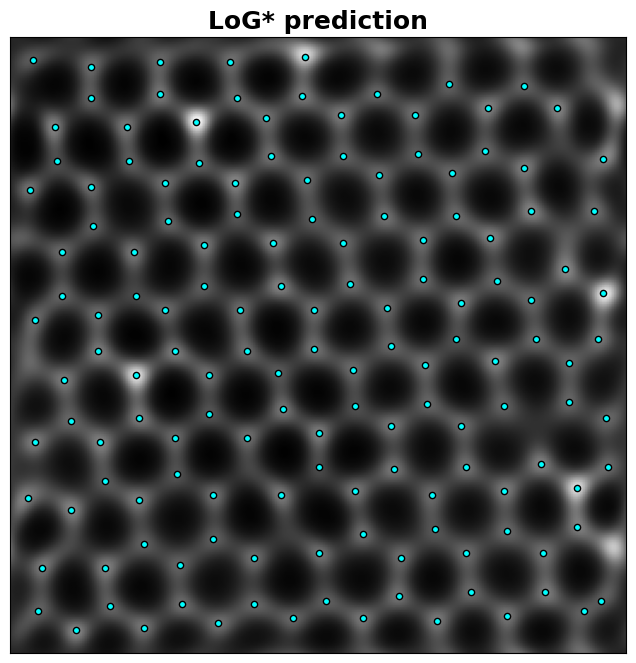

In [50]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(test_img, cmap='gist_gray')

# Scatter plot with filtered data
imglab = ax.scatter(coms[:, 1], coms[:, 0], c="cyan", s=20, cmap='coolwarm', edgecolor='k')
plt.title('LoG* prediction' , fontsize = 18, fontweight = "bold")

ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [51]:
print(len(coms))

147


In [52]:
print(len(coms) - len(blobs_m))

9


**Refinement**

using radius  10 pixels


  0%|          | 0/607 [00:00<?, ?it/s]

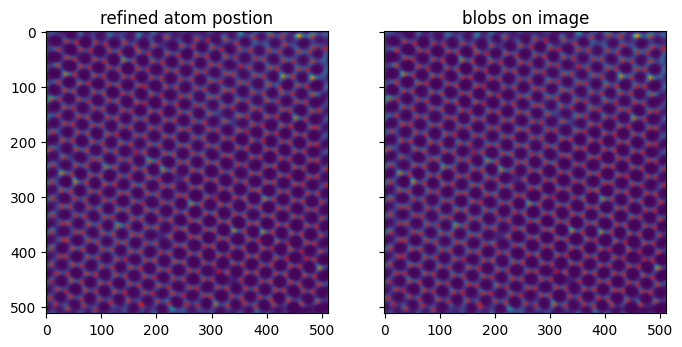

In [ ]:
# ------- Input ------
atom_radius = 10  # in pixel
# ----------------------

image = test_img

#atoms = atom_group['atoms'][()]
atoms = coms
image = image-image.min()

#atom_radius = 2
MaxInt = 0
MinInt = 0
maxDist = 10
sym = pyTEMlib.atom_tools.atom_refine(np.array(image), atoms, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
refined_atoms = np.array(sym['atoms'])

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T)
ax[0].scatter(refined_atoms[:,0],refined_atoms[:,1],  s=10, alpha = 0.3, color = 'red')
ax[0].set_title('refined atom postion')
ax[1].imshow(image.T)
ax[1].scatter(atoms[:, 0], atoms[:, 1], c='r', s=10, alpha = .3);
ax[1].set_title('blobs on image');